In [1]:

import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

print("Imports done. XGBoost available:", HAS_XGB)
sns.set(style="whitegrid")


Imports done. XGBoost available: False


In [2]:
DATA_PATH = "Goals & Assist.csv"  
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nFirst 5 rows:")
display(df.head())

print("\nColumn types and missing values:")
display(pd.DataFrame({"dtype": df.dtypes, "missing": df.isna().sum()}))

Dataset shape: (2274, 34)

Columns: ['Unnamed: 0', 'Player', 'Nation', 'Position', 'Age', 'Matches Played', 'Starts', 'Minutes', '90s Played', 'Goals', 'Assists', 'Goals + Assists', 'Non-Penalty Goals', 'Penalty Goals Made', 'Penalty Attempts', 'Yellow Cards', 'Red Cards', 'xG', 'npxG', 'xAG', 'npxG + xAG', 'Progressive Carries', 'Progressive Passes', 'Progressive Receives', 'Goals Per 90', 'Assists Per 90', 'Goals + Assists Per 90', 'Non-Penalty Goals Per 90', 'Non-Penalty Goals + Assists Per 90', 'xG Per 90', 'xAG Per 90', 'xG + xAG Per 90', 'npxG Per 90', 'npxG + xAG Per 90']

First 5 rows:


,Unnamed: 0,Player,Nation,Position,Age,Matches Played,Starts,Minutes,90s Played,Goals,...,Goals Per 90,Assists Per 90,Goals + Assists Per 90,Non-Penalty Goals Per 90,Non-Penalty Goals + Assists Per 90,xG Per 90,xAG Per 90,xG + xAG Per 90,npxG Per 90,npxG + xAG Per 90
0,0,Mohamed Salah,EGY,AT,32,38,38,3371,37.5,29,...,0.77,0.48,1.25,0.53,1.01,0.67,0.38,1.05,0.49,0.87
1,1,Virgil van Dijk,NED,DF,33,37,37,3330,37.0,3,...,0.08,0.03,0.11,0.08,0.11,0.06,0.02,0.08,0.06,0.08
2,2,Ryan Gravenberch,NED,MT,22,37,37,3160,35.1,0,...,0.00,0.11,0.11,0.00,0.11,0.03,0.09,0.12,0.03,0.12
3,3,Alexis Mac Allister,ARG,MT,25,35,30,2599,28.9,5,...,0.17,0.17,0.35,0.17,0.35,0.10,0.16,0.26,0.10,0.26
4,4,Ibrahima Konaté,FRA,DF,25,31,30,2560,28.4,1,...,0.04,0.07,0.11,0.04,0.11,0.06,0.03,0.10,0.06,0.10



Column types and missing values:


,dtype,missing
Unnamed: 0,int64,0
Player,object,0
Nation,object,0
Position,object,0
Age,int64,0
Matches Played,int64,0
Starts,int64,0
Minutes,int64,0
90s Played,float64,0
Goals,int64,0


In [3]:
def create_extra_features(df):
    df = df.copy()

    # Example features — modify based on your dataset
    if {"home_goals", "away_goals"}.issubset(df.columns):
        df["goal_diff"] = df["home_goals"] - df["away_goals"]

    if "HTFormPts" in df.columns and "ATFormPts" in df.columns:
        df["home_minus_away_form"] = df["HTFormPts"] - df["ATFormPts"]

    if "points" in df.columns and "matches_played" in df.columns:
        df["ppg"] = df["points"] / df["matches_played"].replace(0, np.nan)

    # String length features for form-like columns
    for col in df.columns:
        if df[col].dtype == object:
            df[f"{col}_str_len"] = df[col].astype(str).apply(len)

    return df

df = create_extra_features(df)
print("Extra features created.")


Extra features created.


In [4]:
import pandas as pd
import os

# ---------------- FAST DATA LOAD ----------------
# 1️⃣ If df already exists, use it
if "df" in globals():
    print("Using existing `df` variable. Shape:", df.shape)

# 2️⃣ Otherwise, load from file (hardcoded path or CSV/Excel)
else:
    # Set the path to your dataset (update if needed)
    fp = "Goals & Assist.xlsx"

    # Check if file exists
    if not os.path.exists(fp):
        raise FileNotFoundError(f"Dataset not found at path: {fp}")

    # Load Excel or CSV (Excel is slower; consider CSV or Pickle for speed)
    if fp.lower().endswith((".xls", ".xlsx")):
        df = pd.read_excel(fp)
    else:
        df = pd.read_csv(fp)

    print("Loaded dataset from:", fp, "Shape:", df.shape)

# ---------------- OPTIONAL: Convert to Pickle for super fast reload ----------------
# df.to_pickle("df.pkl")  # Uncomment first time
# df = pd.read_pickle("df.pkl")  # Fast reload in future runs


Using existing `df` variable. Shape: (2274, 37)


In [7]:
# Determine targets dynamically
if "TARGETS" in globals() and isinstance(TARGETS, (list, tuple)) and len(TARGETS) > 0:
    targets_to_model = list(TARGETS)
else:
    found_goals = find_first(cands_goals)
    found_assists = find_first(cands_assists)
    targets_to_model = []
    if found_goals:
        targets_to_model.append(found_goals)
    if found_assists:
        targets_to_model.append(found_assists)
    if not targets_to_model:
        # fallback: try exact names
        for prefer in ["Goals", "Assists"]:
            if prefer in df.columns and prefer not in targets_to_model:
                targets_to_model.append(prefer)
    if not targets_to_model:
        # final fallback: numeric columns
        numeric_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
        if len(numeric_cols_all) >= 1:
            targets_to_model = numeric_cols_all[:min(2, len(numeric_cols_all))]
            print(f"[fallback] Using numeric columns as targets: {targets_to_model}")
        else:
            raise SystemExit("No target columns detected. Provide TARGETS or ensure dataset contains Goals/Assists or numeric columns.")

print("Targets to model (in order):", targets_to_model)
print("If you want specific names, set TARGETS = [...] and re-run the cell.")

# -------------------------
# Feature importance loop
# -------------------------
for target in targets_to_model:

    if "OUTPUT_DIR" not in globals():
        OUTPUT_DIR = "models_output"  

    model_files = [f for f in os.listdir(OUTPUT_DIR)
                   if f.startswith(target + "_best_") and f.endswith(".pkl")]
    if not model_files:
        print("No saved model for target:", target)
        continue

    model_path = os.path.join(OUTPUT_DIR, model_files[0])
    print("\nLoading:", model_path)
    with open(model_path, "rb") as f:
        pipe = pickle.load(f)

    try:
        final_model = pipe.named_steps["model"]
        preproc = pipe.named_steps["preproc"]
    except Exception as e:
        print("Could not unpack pipeline for", target, ":", e)
        continue

    print("\nFeature importance for target:", target, "model:", type(final_model).__name__)

    if not hasattr(final_model, "feature_importances_"):
        print("Model has no feature_importances_ attribute (not a tree-based model).")
        continue

    importances = final_model.feature_importances_

    feat_names = None
    try:
        if hasattr(preproc, "get_feature_names_out"):
            feat_names = preproc.get_feature_names_out()
            feat_names = [str(x) for x in feat_names] 
    except Exception:
        feat_names = None

    if feat_names is None:
        feat_names = []

        if preproc == "passthrough":
            feat_names = [f"f{i}" for i in range(len(importances))]
        else:
            try:
                transformers = preproc.transformers_ 
            except Exception:
                transformers = []

            for name, transformer, cols in transformers:
                if cols == "drop" or cols is None:
                    continue

                if name.lower().startswith("num") or name.lower().startswith("n"):
                    feat_names.extend(list(cols))
                else:
                    ohe = None
                    try:
                        if hasattr(transformer, "named_steps"):
                            for step in transformer.named_steps.values():
                                if hasattr(step, "get_feature_names_out") or hasattr(step, "categories_"):
                                    ohe = step
                                    break
                        else:
                            if hasattr(transformer, "get_feature_names_out") or hasattr(transformer, "categories_"):
                                ohe = transformer
                    except Exception:
                        ohe = None

                    if ohe is None:
                        feat_names.extend(list(cols))
                    else:
                        try:
                            names = ohe.get_feature_names_out(cols)
                            feat_names.extend([str(n) for n in names])
                        except Exception:
                            try:
                                cats = ohe.categories_
                                for col_name, cat_vals in zip(cols, cats):
                                    for val in cat_vals:
                                        feat_names.append(f"{col_name}__{val}")
                            except Exception:
                                feat_names.extend(list(cols))

        if len(feat_names) != len(importances):
            feat_names = [f"f{i}" for i in range(len(importances))]

    fi_df = pd.DataFrame({"feature": feat_names, "importance": importances})
    fi_df = fi_df.sort_values("importance", ascending=False).reset_index(drop=True)

    display(fi_df.head(30))

    plt.figure(figsize=(8, min(0.4 * len(fi_df.head(30)), 10)))  
    sns.barplot(data=fi_df.head(30), x="importance", y="feature")
    plt.title(f"{target} Feature importance ({type(final_model).__name__})")
    plt.tight_layout()
    plt.show()


Targets to model (in order): ['Goals', 'Assists']
If you want specific names, set TARGETS = [...] and re-run the cell.

Loading: models_output\Goals_best_lin.pkl

Feature importance for target: Goals model: LinearRegression
Model has no feature_importances_ attribute (not a tree-based model).

Loading: models_output\Assists_best_lin.pkl

Feature importance for target: Assists model: LinearRegression
Model has no feature_importances_ attribute (not a tree-based model).


In [9]:
# ---------- IMPORTS ----------
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# ---------- helpers ----------
cv = KFold(n_splits=3, shuffle=True, random_state=42)

def make_onehot():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        # For older sklearn versions
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def get_feature_names_from_preprocessor(preproc, X_sample, cat_cols):
    """
    Extract feature names from a ColumnTransformer preprocessor.
    Works with OneHotEncoder and passthrough numeric columns.
    """
    # Fit preprocessor if not already fitted
    try:
        preproc.fit(X_sample)
    except Exception:
        pass

    names = []

    if isinstance(preproc, ColumnTransformer):
        named = preproc.named_transformers_
        
        # OneHotEncoded categorical names
        if "cat" in named:
            try:
                ohe = named["cat"].named_steps["onehot"]
                ohe_names = list(ohe.get_feature_names_out(cat_cols)) if hasattr(ohe, "get_feature_names_out") else []
            except Exception:
                ohe_names = []
        else:
            ohe_names = []

        # Numeric/passthrough column names
        passthrough = [c for c in X_sample.columns.tolist() if c not in cat_cols]

        names = ohe_names + passthrough
    else:
        # If not a ColumnTransformer, just return all columns
        names = X_sample.columns.tolist()

    return names


Loaded dataset from: Goals & Assist.xlsx Shape: (2274, 37)
Targets to model (in order): ['Goals', 'Assists']

TRAINING TARGET: Goals
Rows available: 2274


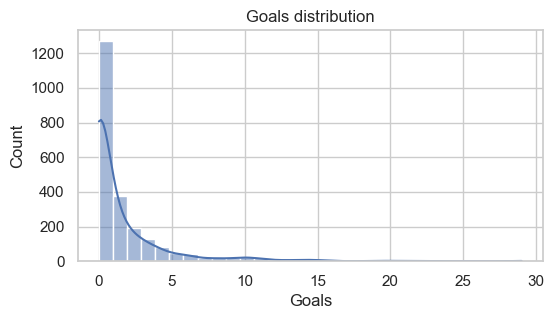


-> training: rf
CV RMSE (mean): 0.433900
Test RMSE: 0.346062, MAE: 0.054088, R2: 0.986012

-> training: lin
CV RMSE (mean): 0.001341
Test RMSE: 0.001515, MAE: 0.000427, R2: 1.000000

-> training: ridge
CV RMSE (mean): 0.010466
Test RMSE: 0.012568, MAE: 0.006532, R2: 0.999982


,target,model,cv_rmse,test_rmse,test_mae,test_r2,best_params
1,Goals,lin,0.001341,0.001515,0.000427,1.000000,{'model__fit_intercept': True}
2,Goals,ridge,0.010466,0.012568,0.006532,0.999982,{'model__alpha': 1.0}
0,Goals,rf,0.433900,0.346062,0.054088,0.986012,"{'model__max_depth': None, 'model__n_estimator..."


Saved best model to: models_output\Goals_best_lin.pkl

TRAINING TARGET: Assists
Rows available: 2274


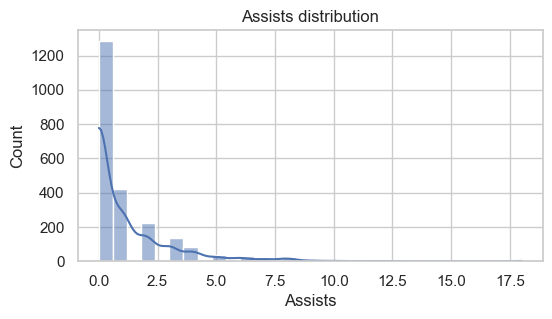


-> training: rf
CV RMSE (mean): 0.356700
Test RMSE: 0.308395, MAE: 0.090440, R2: 0.970441

-> training: lin
CV RMSE (mean): 0.000983
Test RMSE: 0.001110, MAE: 0.000313, R2: 1.000000

-> training: ridge
CV RMSE (mean): 0.050232
Test RMSE: 0.049203, MAE: 0.029020, R2: 0.999248


,target,model,cv_rmse,test_rmse,test_mae,test_r2,best_params
1,Assists,lin,0.000983,0.001110,0.000313,1.000000,{'model__fit_intercept': True}
2,Assists,ridge,0.050232,0.049203,0.029020,0.999248,{'model__alpha': 1.0}
0,Assists,rf,0.356700,0.308395,0.090440,0.970441,"{'model__max_depth': None, 'model__n_estimator..."


Saved best model to: models_output\Assists_best_lin.pkl

All targets processed. Models saved in: models_output


,target,model,cv_rmse,test_rmse,test_mae,test_r2,best_params
4,Assists,lin,0.000983,0.001110,0.000313,1.000000,{'model__fit_intercept': True}
1,Goals,lin,0.001341,0.001515,0.000427,1.000000,{'model__fit_intercept': True}
2,Goals,ridge,0.010466,0.012568,0.006532,0.999982,{'model__alpha': 1.0}
5,Assists,ridge,0.050232,0.049203,0.029020,0.999248,{'model__alpha': 1.0}
3,Assists,rf,0.356700,0.308395,0.090440,0.970441,"{'model__max_depth': None, 'model__n_estimator..."
0,Goals,rf,0.433900,0.346062,0.054088,0.986012,"{'model__max_depth': None, 'model__n_estimator..."


In [10]:
# ------------------ AUTO-DETECT GOALS & ASSISTS ------------------
cands_goals = ["Goals", "goals_scored", "goals", "FTHG", "FTAG", "home_goals", "away_goals"]
cands_assists = ["Assists", "assists"]


# find first matching column in df
found_goals = next((c for c in cands_goals if c in df.columns), None)
found_assists = next((c for c in cands_assists if c in df.columns), None)

targets = []
if found_goals:
    targets.append(found_goals)
if found_assists:
    targets.append(found_assists)

if not targets:
    raise ValueError("No goal/assist-like target column found. Update cands_goals/cands_assists or set TARGETS manually.")

print("Loaded dataset from:", "Goals & Assist.xlsx", "Shape:", df.shape)
print("Targets to model (in order):", targets)
TARGETS = targets  # use this in training loop

# ------------------ TRAINING LOOP (GOALS + ASSISTS) ------------------
overall_reports = []

for target in TARGETS:
    print("\n" + "="*60)
    print("TRAINING TARGET:", target)
    print("="*60)

    X_all = df.drop(columns=[target]).copy()
    y_all = df[target].copy()
    mask = y_all.notna()
    X_all = X_all.loc[mask].reset_index(drop=True)
    y_all = y_all.loc[mask].reset_index(drop=True)
    print("Rows available:", X_all.shape[0])

    numeric_cols = X_all.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X_all.select_dtypes(include=["object","category","bool"]).columns.tolist()

    transformers = []
    if numeric_cols:
        transformers.append(("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                                               ("scaler", StandardScaler())]), numeric_cols))
    if cat_cols:
        transformers.append(("cat", Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
                                              ("onehot", make_onehot())]), cat_cols))

    preprocessor = ColumnTransformer(transformers, remainder="drop") if transformers else "passthrough"

    models_and_grids = [
        ("rf", RandomForestRegressor(random_state=42), {"model__n_estimators":[100], "model__max_depth":[None, 8]}),
        ("lin", LinearRegression(), {"model__fit_intercept":[True]}),
        ("ridge", Ridge(random_state=42), {"model__alpha":[1.0, 5.0]})
    ]
    if HAS_XGB:
        models_and_grids.append(("xgb", XGBRegressor(random_state=42, verbosity=0, n_jobs=-1),
                                 {"model__n_estimators":[100], "model__learning_rate":[0.05]}))

    best_local = None
    best_name = None
    best_test_rmse = np.inf
    reports = []

    # Optional distribution plot
    try:
        plt.figure(figsize=(6,3))
        sns.histplot(y_all, bins=30, kde=True)
        plt.title(f"{target} distribution")
        plt.show()
    except Exception:
        pass

    # Train models
    for name, estimator, grid in models_and_grids:
        print(f"\n-> training: {name}")
        pipe = Pipeline([("preproc", preprocessor), ("model", estimator)])
        gs = GridSearchCV(pipe, grid, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
        gs.fit(X_all, y_all)

        try:
            neg_mse = cross_val_score(gs.best_estimator_, X_all, y_all, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)
            rmse_scores = np.sqrt(-neg_mse)
            cv_rmse = float(np.mean(rmse_scores))
        except Exception:
            cv_rmse = float("nan")
        print(f"CV RMSE (mean): {cv_rmse:.6f}")

        X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
        best_est = gs.best_estimator_
        best_est.fit(X_train, y_train)
        y_pred = best_est.predict(X_test)

        test_rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
        test_mae = float(mean_absolute_error(y_test, y_pred))
        test_r2 = float(r2_score(y_test, y_pred))
        print(f"Test RMSE: {test_rmse:.6f}, MAE: {test_mae:.6f}, R2: {test_r2:.6f}")

        reports.append({"target": target, "model": name, "cv_rmse": cv_rmse, "test_rmse": test_rmse,
                        "test_mae": test_mae, "test_r2": test_r2, "best_params": gs.best_params_})

        if test_rmse < best_test_rmse:
            best_test_rmse = test_rmse
            best_local = best_est
            best_name = name
            best_X_test, best_y_test, best_y_pred = X_test, y_test, y_pred

    # Show target report
    display(pd.DataFrame(reports).sort_values("test_rmse"))

    # Save best model
    if best_local:
        save_path = os.path.join(OUTPUT_DIR, f"{target}_best_{best_name}.pkl")
        with open(save_path, "wb") as fh:
            pickle.dump(best_local, fh)
        print("Saved best model to:", save_path)
        overall_reports.extend(reports)

print("\nAll targets processed. Models saved in:", OUTPUT_DIR)
display(pd.DataFrame(overall_reports).sort_values("test_rmse").head(20))


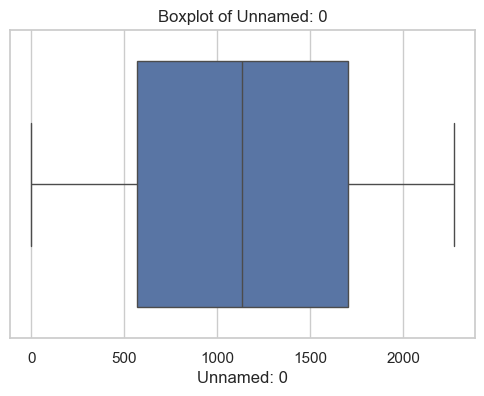

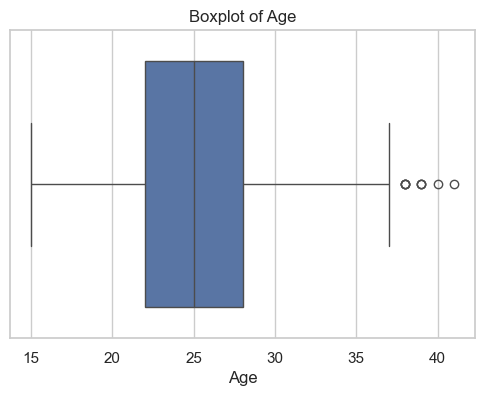

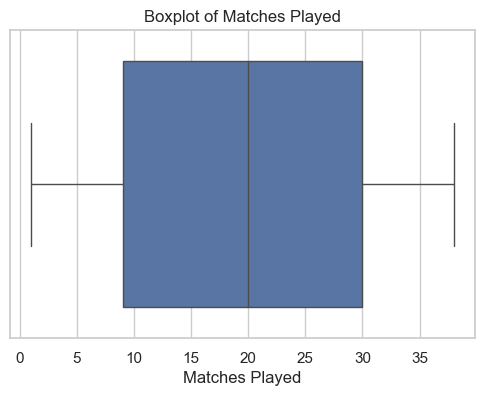

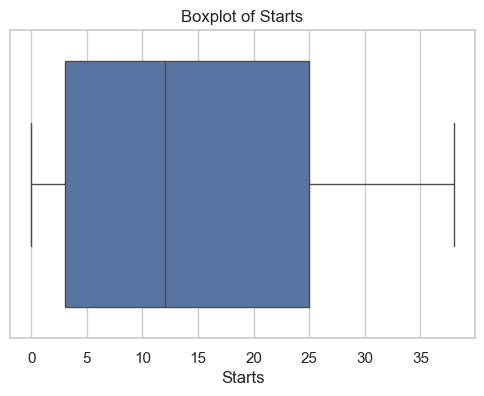

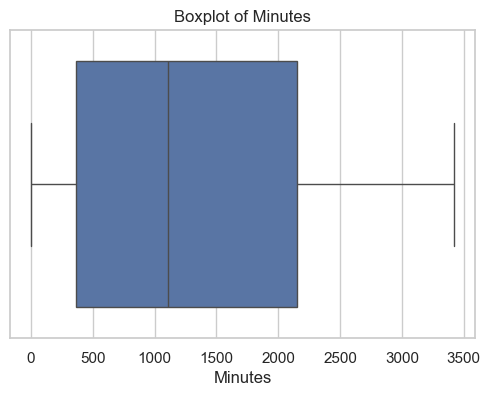

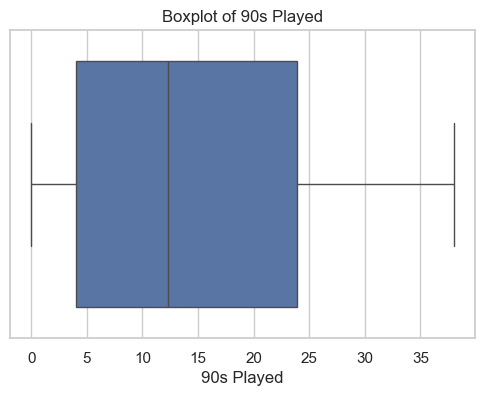

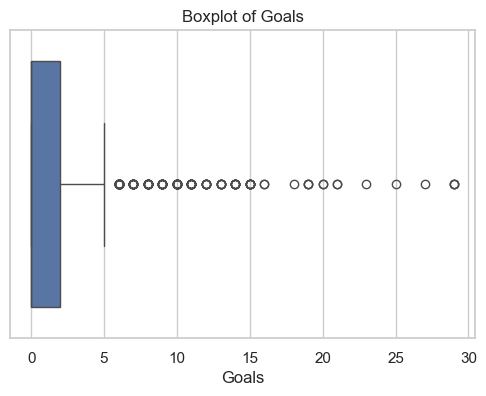

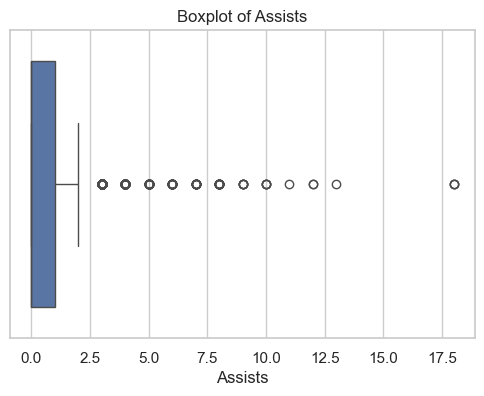

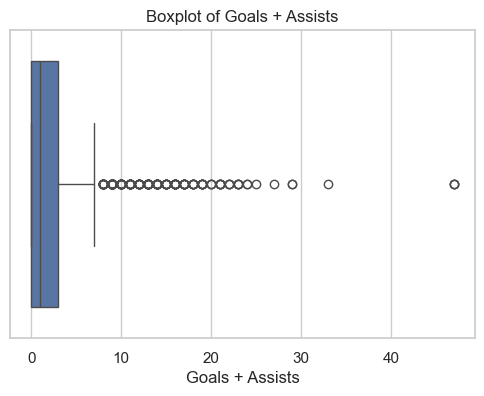

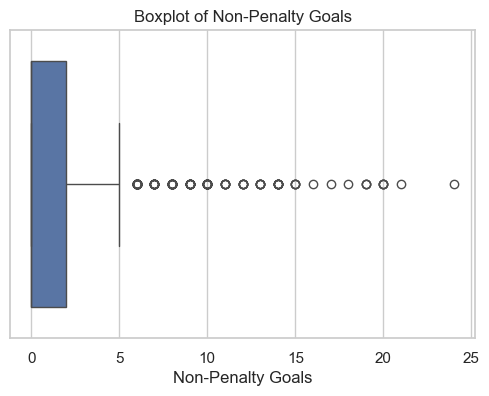

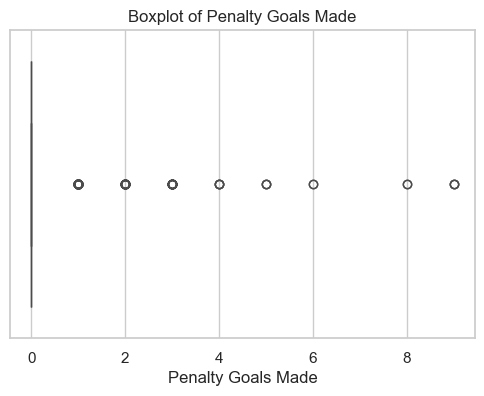

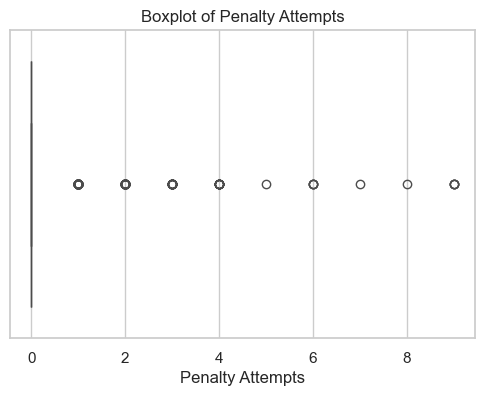

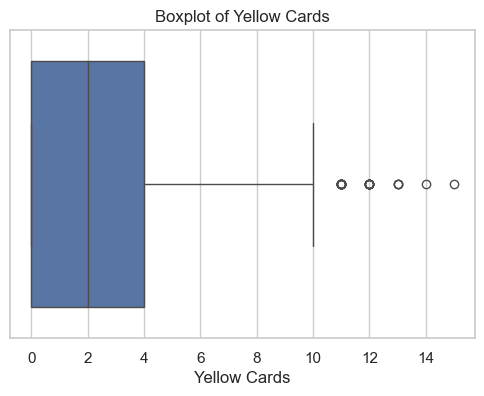

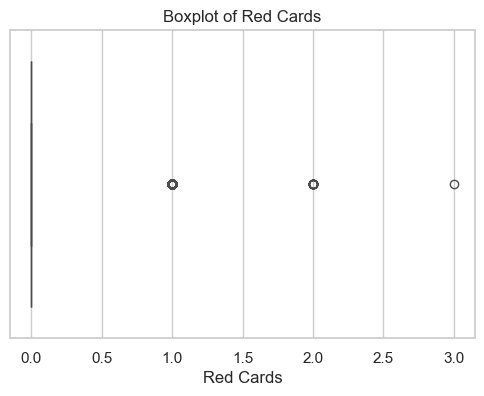

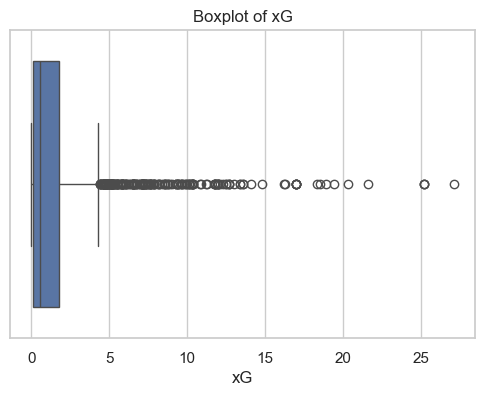

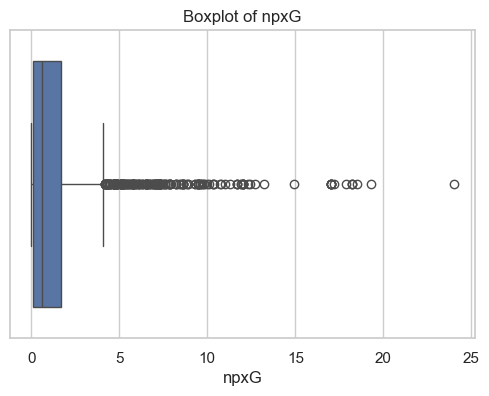

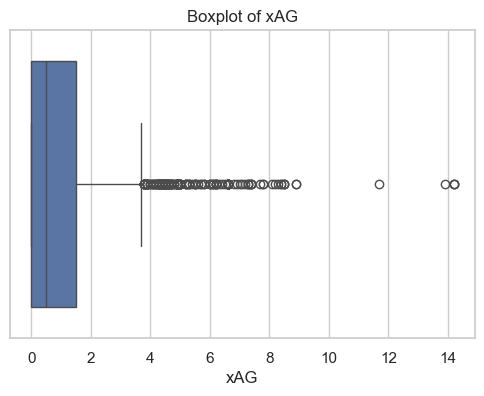

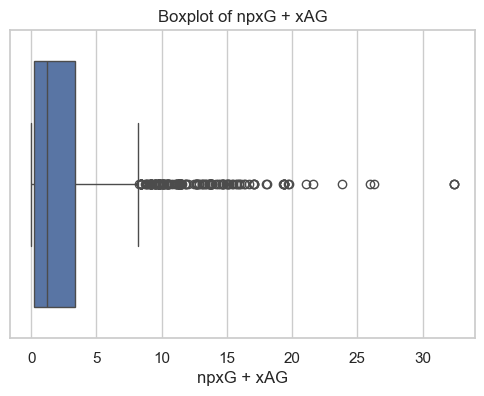

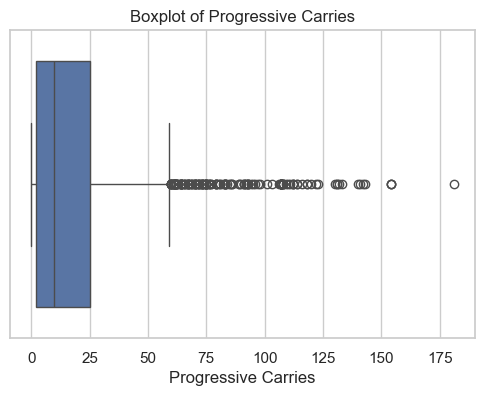

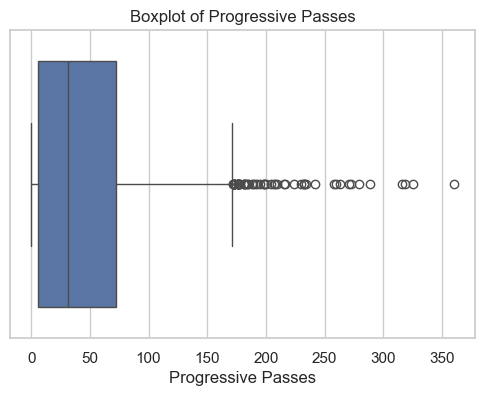

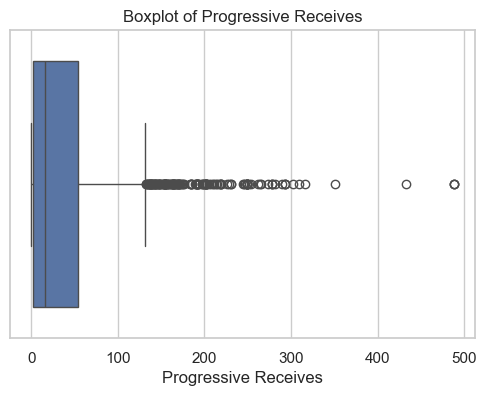

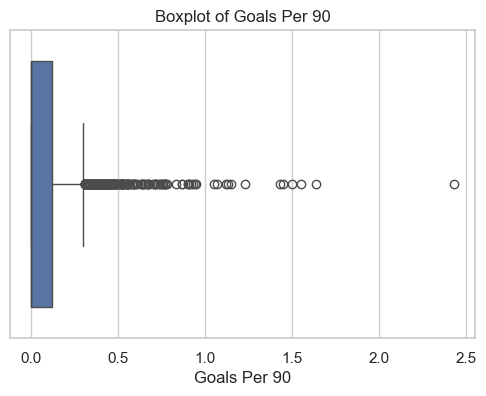

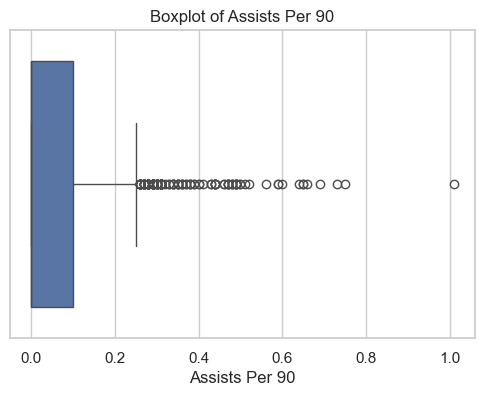

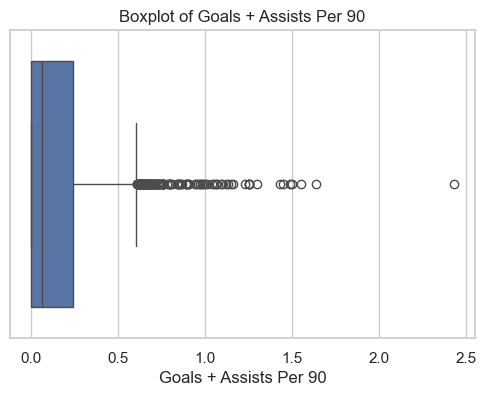

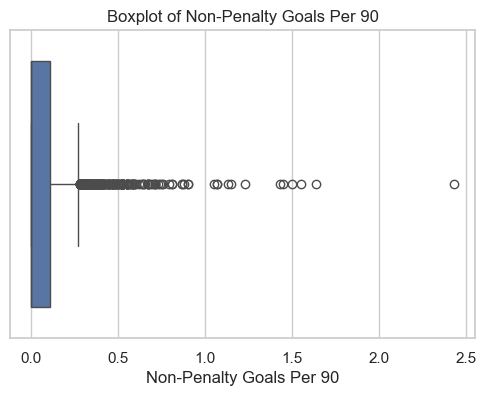

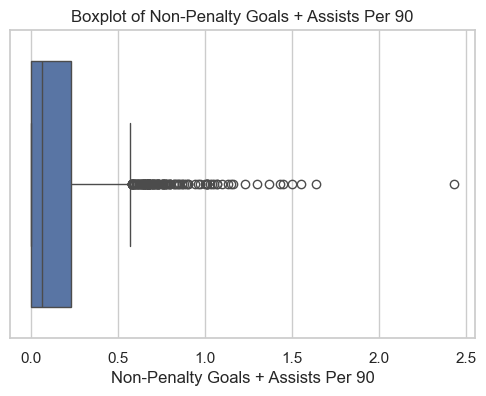

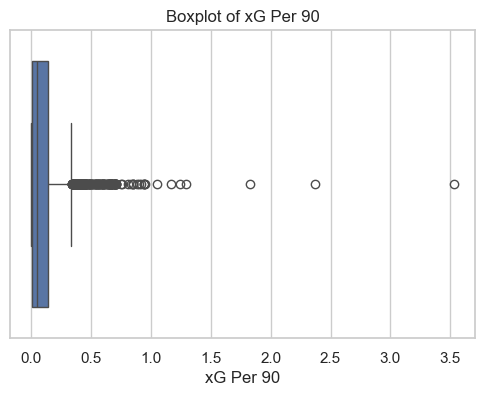

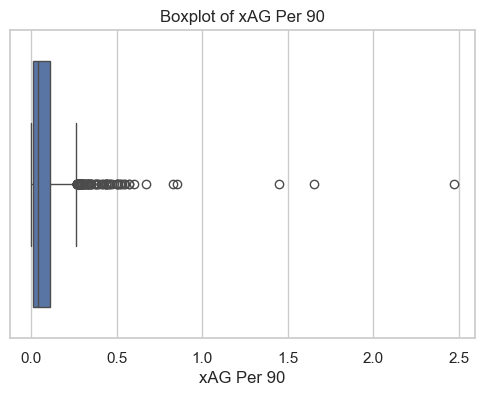

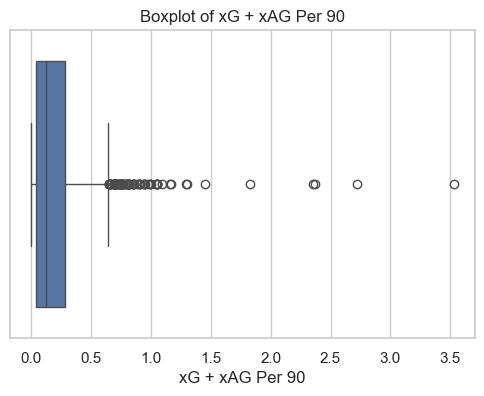

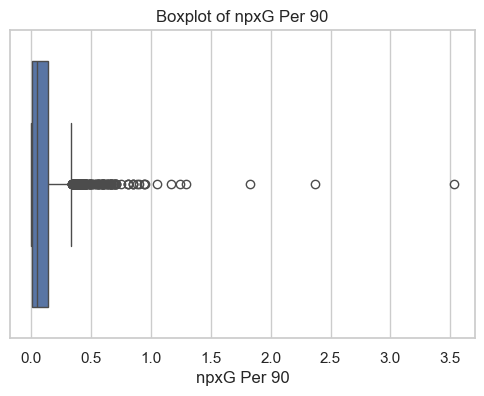

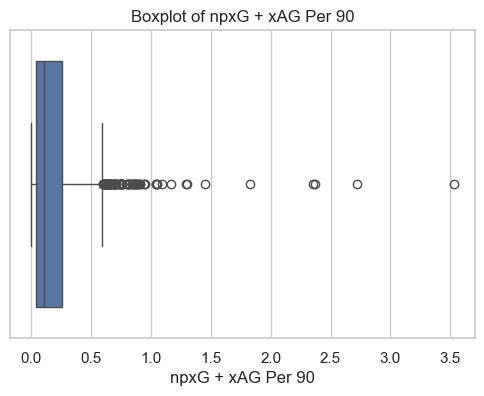

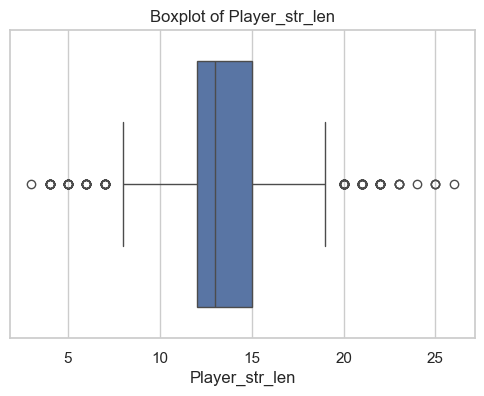

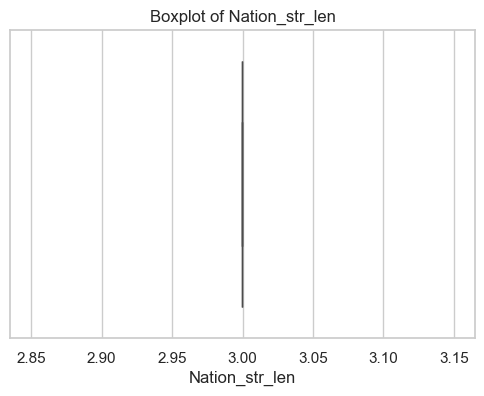

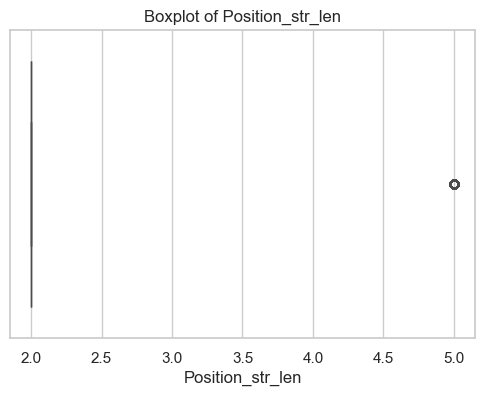

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


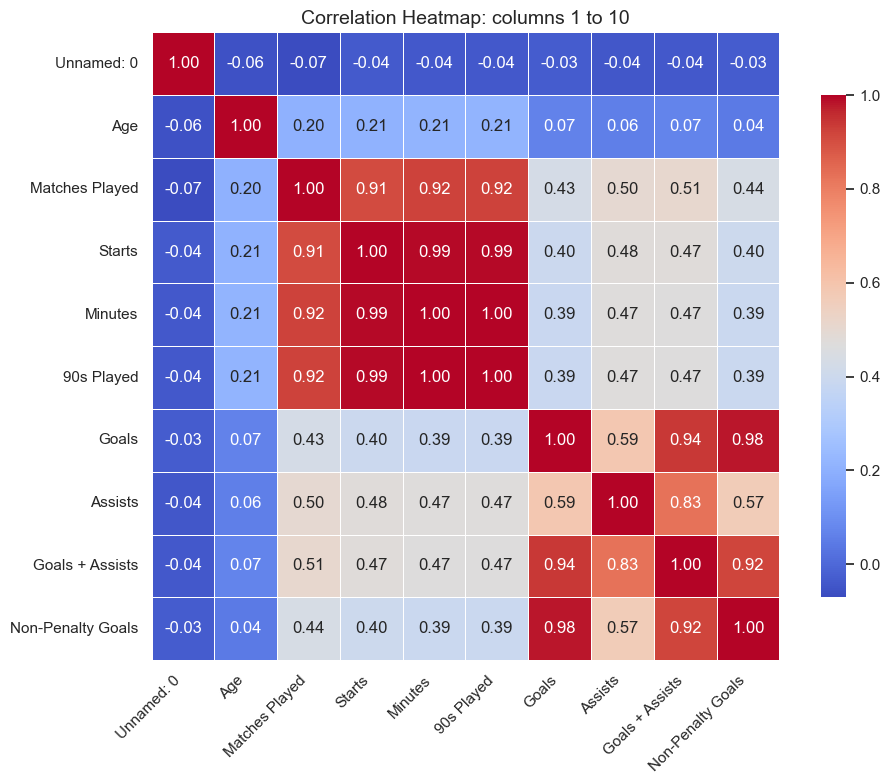

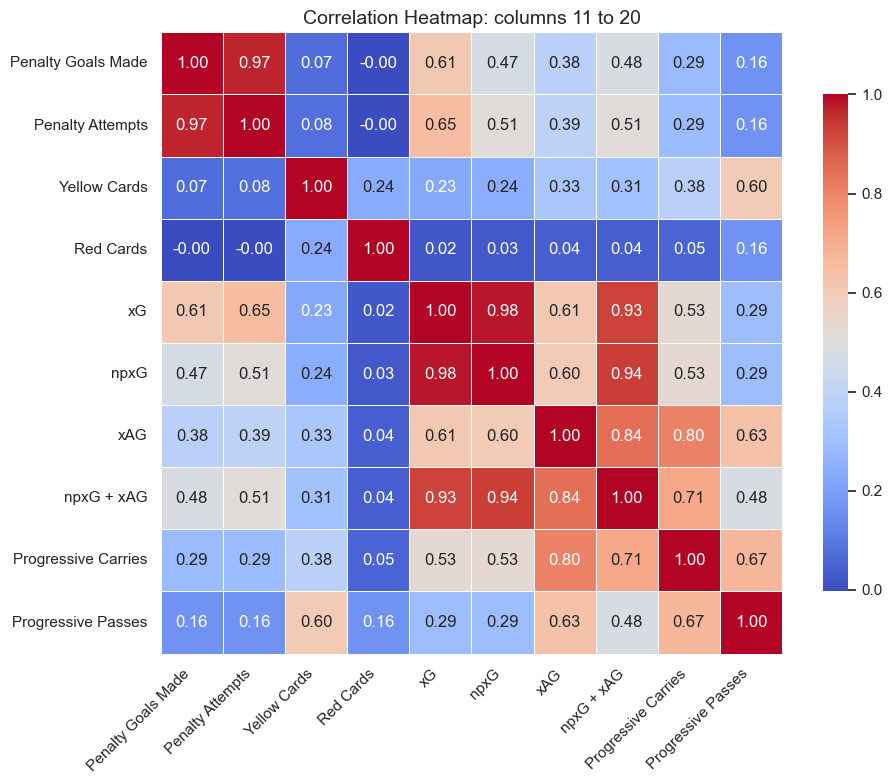

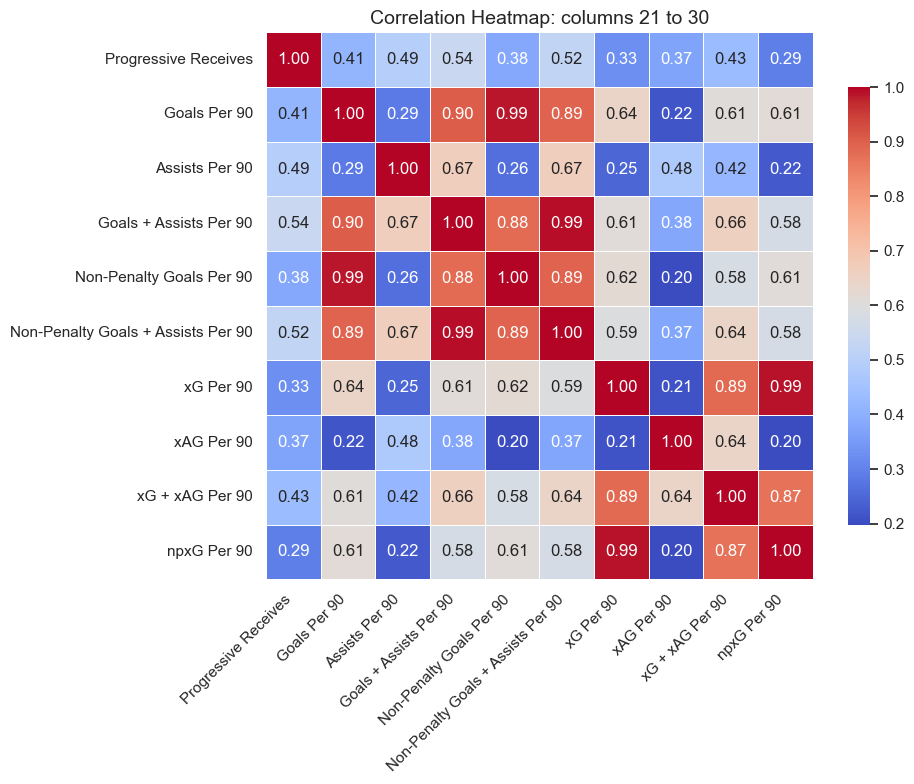

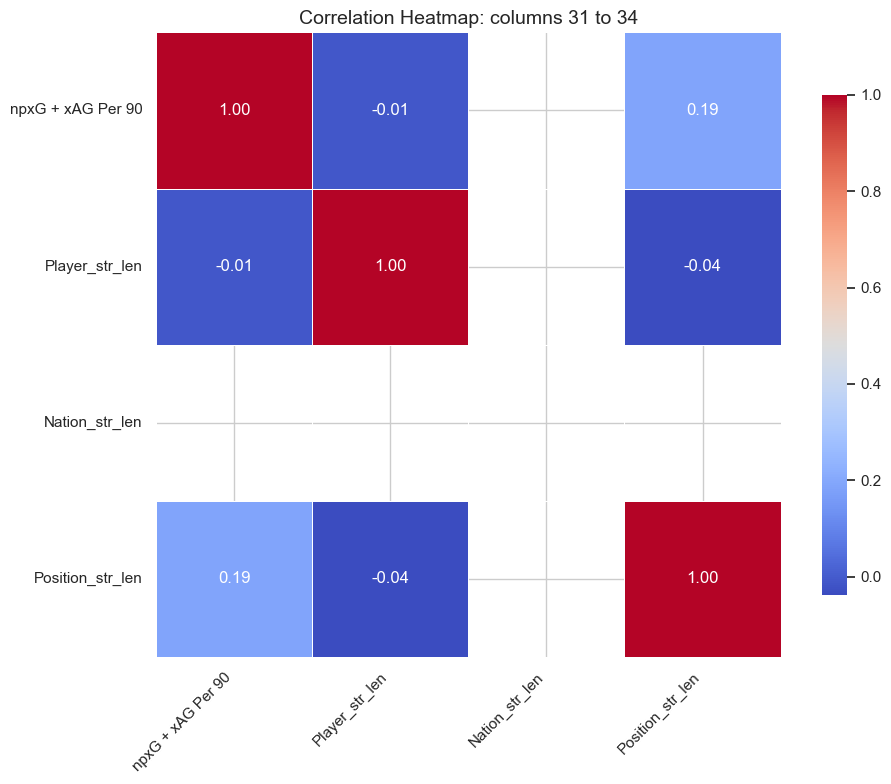

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

numeric_cols = df.select_dtypes(include=['int64','float64']).columns
group_size = 10  

for i in range(0, len(numeric_cols), group_size):
    group = numeric_cols[i:i+group_size]
    corr_matrix = df[group].corr()
    
    plt.figure(figsize=(10,8))
    sns.heatmap(
        corr_matrix, 
        annot=True, fmt=".2f", cmap="coolwarm",
        linewidths=0.5, cbar_kws={"shrink":0.8}, square=True
    )
    plt.title(f"Correlation Heatmap: columns {i+1} to {i+len(group)}", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [16]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

TARGETS_TO_USE = ["Goals", "Assists"]  # match saved model filenames exactly
OUTPUT_DIR = "models_output"

for target in TARGETS_TO_USE:

    model_files = [f for f in os.listdir(OUTPUT_DIR)
                   if f.startswith(target + "_best_") and f.endswith(".pkl")]
    if not model_files:
        print("No saved model for target:", target)
        continue

    model_path = os.path.join(OUTPUT_DIR, model_files[0])
    print("\nLoading:", model_path)
    with open(model_path, "rb") as f:
        pipe = pickle.load(f)

    try:
        final_model = pipe.named_steps["model"]
        preproc = pipe.named_steps["preproc"]
    except Exception as e:
        print("Could not unpack pipeline for", target, ":", e)
        continue

    if not hasattr(final_model, "feature_importances_"):
        print("Model has no feature_importances_ attribute.")
        continue

    importances = final_model.feature_importances_

    # Simple feat_names extraction (assumes passthrough)
    if hasattr(preproc, "get_feature_names_out"):
        feat_names = preproc.get_feature_names_out()
        feat_names = [str(x) for x in feat_names]
    else:
        feat_names = [f"f{i}" for i in range(len(importances))]

    fi_df = pd.DataFrame({"feature": feat_names, "importance": importances})
    fi_df = fi_df.sort_values("importance", ascending=False).reset_index(drop=True)

    print(f"\nFeature importance for {target}:")
    print(fi_df.head(30))

    plt.figure(figsize=(8, min(0.4 * len(fi_df.head(30)), 10)))
    sns.barplot(data=fi_df.head(30), x="importance", y="feature")
    plt.title(f"{target} Feature importance ({type(final_model).__name__})")
    plt.tight_layout()
    plt.show()



Loading: models_output\Goals_best_lin.pkl
Model has no feature_importances_ attribute.

Loading: models_output\Assists_best_lin.pkl
Model has no feature_importances_ attribute.
